In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/Users/treycole/Codes/WanPy/top_obstruction


In [2]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [3]:
### Trial wavefunctions

# only one should be true
random = False
low_E = False
omit = True

if random:
    omit_num = 2
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
elif omit:
    omit_sites = 6
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
elif low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ

if random:
    save_sfx = model_str + f'_tfxs={tf_list}'
else:
    save_sfx = model_str + f'_tfx={np.array(tf_list, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.4_tfx=[0 2 4]


In [4]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
    
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

loc_steps = np.load(f"{file_name}.npy", allow_pickle=True).item()

In [5]:
for key, val in loc_steps.items():
    print(f"{key} Omega = {sum(val['Omega'])}")

P Omega = 0.8147474545928515
P+ML Omega = 0.8131431987693966
P+SS+P Omega = 0.7058332625131949
P+SS+P+ML Omega = 0.7045594457098602


In [6]:
loc_steps

{'P': {'Omega': array([0.27158248, 0.27158248, 0.27158248]),
  'Omega_i': np.float64(0.7388768356161961),
  'Omega_til': np.float64(0.07587061897668325),
  'centers': array([[0.16743062, 0.16743062],
         [0.16743062, 0.66513876],
         [0.66513876, 0.16743062]])},
 'P+ML': {'Omega': array([0.27104773, 0.27104773, 0.27104773]),
  'Omega_i': np.float64(0.7388768356173046),
  'Omega_til': np.float64(0.07426636315211552),
  'centers': array([[0.1674412 , 0.1674412 ],
         [0.1674412 , 0.66511759],
         [0.66511759, 0.1674412 ]]),
  'iter_num': 100000},
 'P+SS+P': {'Omega': array([0.23527775, 0.23527775, 0.23527775]),
  'Omega_i': np.float64(0.6577988768559919),
  'Omega_til': np.float64(0.04803438565724734),
  'centers': array([[0.15994304, 0.15994304],
         [0.15994304, 0.68011393],
         [0.68011393, 0.15994304]]),
  'iter_num': 100000},
 'P+SS+P+ML': {'Omega': array([0.23485315, 0.23485315, 0.23485315]),
  'Omega_i': np.float64(0.6577988768572425),
  'Omega_til': 

# Generating Maximally Localized Wannier Functions

In [52]:
nks = 20, 20
WF = Wannier(model, nks)
loc_steps = {}

In [53]:
WF.single_shot(tf_list)
WF.report()
loc_steps["P"] = {"Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til, "centers": WF.get_centers()}

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.27158
w_1 --> 0.27158
w_2 --> 0.27158
Centers:
w_0 --> [0.16743 0.16743]
w_1 --> [0.16743 0.66514]
w_2 --> [0.66514 0.16743]
Omega_i = 0.7388768356161961
Omega_tilde = 0.07587061897668325


In [58]:
iter_num = 100000

WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-30, grad_min=1e-12, verbose=True)

loc_steps["P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

WF.report()

0 Omega_til = 0.07419941478691222, Grad mag: 3.2786043822725925e-13
1 Omega_til = 0.07414102336699346, Grad mag: 3.6092058194568537e-13
2 Omega_til = 0.07408991727337043, Grad mag: 2.9413950331446476e-13
3 Omega_til = 0.07404009664812196, Grad mag: 3.9435823228824706e-13
4 Omega_til = 0.07399634793116669, Grad mag: 2.8521089039283035e-13
5 Omega_til = 0.07395357237352304, Grad mag: 3.404439963030839e-13
6 Omega_til = 0.07391590282761007, Grad mag: 3.534883150725792e-13
7 Omega_til = 0.0738826521449888, Grad mag: 3.2300526345369133e-13
8 Omega_til = 0.07384998771396734, Grad mag: 2.920442339186193e-13
9 Omega_til = 0.07381789551521029, Grad mag: 2.732916373555171e-13
10 Omega_til = 0.07378636196168599, Grad mag: 3.3714569741136566e-13
11 Omega_til = 0.07375846056202032, Grad mag: 3.3490153208196163e-13
12 Omega_til = 0.07373099116030392, Grad mag: 3.256706498828982e-13
13 Omega_til = 0.07370394470522738, Grad mag: 3.6296036966146126e-13
14 Omega_til = 0.07367996639977674, Grad mag: 3.21

In [62]:
nks = 20, 20
WF = Wannier(model, nks)

# initial projection
WF.single_shot(tf_list)

# subspace selection
iter_num = 100000
WF.subspace_selec(iter_num=iter_num, tol=1e-15, verbose=True)

# second projection
psi_til_til = WF.get_psi_tilde(
        WF.tilde_states._psi_wfs, WF.trial_wfs, 
        state_idx=list(range(WF.tilde_states._psi_wfs.shape[2]))
        )
WF.set_tilde_states(psi_til_til, cell_periodic=False)

loc_steps["P+SS+P"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

# max-loc
iter_num = 100000
WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-30, grad_min=1e-11, verbose=True)

loc_steps["P+SS+P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}


sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
np.save(file_name, loc_steps)

sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
np.save(file_name, WF)

0 Omega_I: 0.7351242262300651
1 Omega_I: 0.7318708508835882
2 Omega_I: 0.7290033204981726
3 Omega_I: 0.7264422430421196
4 Omega_I: 0.7241292655801895
5 Omega_I: 0.7220202214129708
6 Omega_I: 0.7200809965885923
7 Omega_I: 0.7182848310727317
8 Omega_I: 0.7166104648979735
9 Omega_I: 0.7150408208065453
10 Omega_I: 0.713562045435643
11 Omega_I: 0.7121627987871648
12 Omega_I: 0.7108337200784366
13 Omega_I: 0.7095670213309428
14 Omega_I: 0.7083561748922719
15 Omega_I: 0.7071956709131065
16 Omega_I: 0.7060808274938474
17 Omega_I: 0.7050076408723039
18 Omega_I: 0.7039726663213518
19 Omega_I: 0.7029729227918304
20 Omega_I: 0.7020058160559173
21 Omega_I: 0.7010690763684173
22 Omega_I: 0.7001607075986562
23 Omega_I: 0.6992789454844223
24 Omega_I: 0.6984222231853773
25 Omega_I: 0.6975891427126061
26 Omega_I: 0.696778451115211
27 Omega_I: 0.6959890205392723
28 Omega_I: 0.6952198314554037
29 Omega_I: 0.6944699584920232
30 Omega_I: 0.6937385584216893
31 Omega_I: 0.6930248599344567
32 Omega_I: 0.692328

In [66]:
for key, val in loc_steps.items():
    print(f"{key} Omega = {sum(val['Omega'])}")

P Omega = 0.8147474545928515
P+ML Omega = 0.8121375525940336
P+SS+P Omega = 0.7058331037521572
P+SS+P+ML Omega = 0.7045168845670995


In [65]:
loc_steps

{'P': {'Omega': array([0.27158248, 0.27158248, 0.27158248]),
  'Omega_i': np.float64(0.7388768356161961),
  'Omega_til': np.float64(0.07587061897668325),
  'centers': array([[0.16743062, 0.16743062],
         [0.16743062, 0.66513876],
         [0.66513876, 0.16743062]])},
 'P+ML': {'Omega': array([0.27071252, 0.27071252, 0.27071252]),
  'Omega_i': np.float64(0.7388768356184698),
  'Omega_til': np.float64(0.07326071697559468),
  'centers': array([[0.16745208, 0.16745208],
         [0.16745208, 0.66509585],
         [0.66509585, 0.16745208]]),
  'iter_num': 100000},
 'P+SS+P': {'Omega': array([0.2352777, 0.2352777, 0.2352777]),
  'Omega_i': np.float64(0.6577988768571288),
  'Omega_til': np.float64(0.048034226895059165),
  'centers': array([[0.1599431 , 0.1599431 ],
         [0.1599431 , 0.68011379],
         [0.68011379, 0.1599431 ]]),
  'iter_num': 100000},
 'P+SS+P+ML': {'Omega': array([0.23483896, 0.23483896, 0.23483896]),
  'Omega_i': np.float64(0.6577988768583225),
  'Omega_til': np

# Plotting

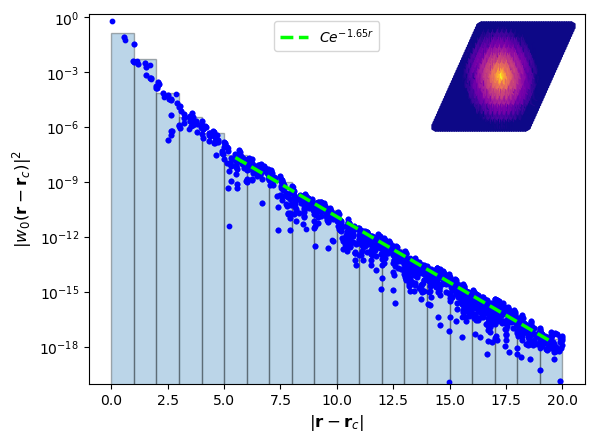

In [5]:
idx = 0
fig, ax = WF.plot_decay(idx, fit_rng=[5, 20], return_fig=True)
ax.legend(bbox_to_anchor=(0.6, 1.0))
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')  # You can adjust size and location
fig, inset_ax = WF.plot_density(idx, show_lattice=False, lat_size=2, cbar=False, fig=fig, ax=inset_ax, return_fig=True)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('off')
plt.savefig(f'images/decay_and_dens_{save_sfx}.png', dpi=700)

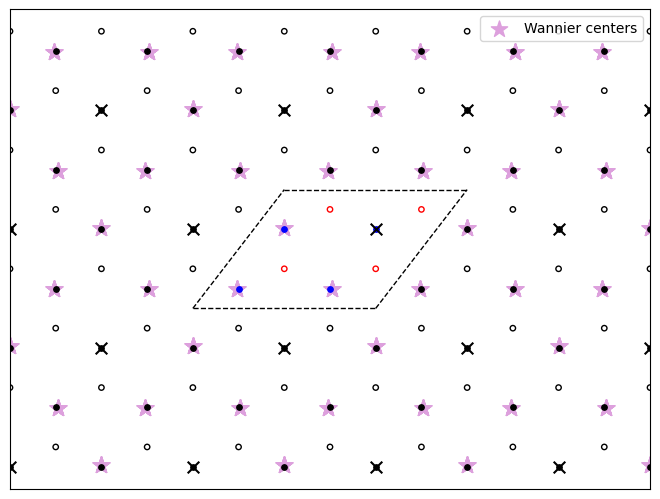

In [6]:
title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

kwargs_centers = {'s': 150, 'marker':'*', 'c':'plum', 'alpha':1} 
kwargs_omit = {'s': 70, 'marker':'x', 'c':'k', 'zorder':3} 
kwargs_lat = {'s': 15, 'marker':'o', 'c':'k'} 

fig, ax = WF.plot_centers(
    title=title, omit_sites=[omit_sites], section_home_cell=True, 
    color_home_cell=True, translate_centers=True, kwargs_centers=kwargs_centers, 
    kwargs_lat=kwargs_lat, kwargs_omit=kwargs_omit, pmx=3.5, pmy=3.5, legend=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

sv_dir = 'images'
sv_prefix = 'Wan_centers'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}.png"

plt.subplots_adjust(top=1, left=0, bottom=0, right=1)

plt.savefig(file_name, dpi=700)

In [7]:
u_energy = WF.energy_eigstates.get_states()["Cell periodic"]  # energy eigenstates
u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
u_tilde = WF.tilde_states.get_states()["Cell periodic"]  # reduced tilde states

## Projectors on full mesh
P, Q = WF.energy_eigstates.get_projector(return_Q=True)  # full band projector
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj())  # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ[..., :, :]  # occ complement
P_tilde, Q_tilde = WF.tilde_states.get_projector(return_Q=True)  # tilde space projectors
P_diff = P_occ - P_tilde  # complementary subspace

eigvals, eigvecs = np.linalg.eigh(P_diff)  # states spanning complement
u_comp = eigvecs[..., :, -1]  # take state with non-zero eigval
u_comp = u_comp[..., np.newaxis, :]  # single state

In [8]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)

# Complementary subspace interpolated energies and states
interp_energies_comp, interp_unk_comp = WF.interp_energies(k_vec, u_tilde=u_comp, ret_eigvecs=True) 

Hermiticity Check:  True
Hermiticity Check:  True


In [11]:
interp_energies.imag

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [21]:
# fig, ax = model.plot_bands(
#     k_path, nk=501, k_label=k_label, scat_size=2, red_lat_idx=high_E_sites, cmap='plasma'
#     )

# # deficient bands
# for n in range(interp_energies.shape[-1]):
#     ax.plot(k_dist, interp_energies[:, n], lw=2, c='deepskyblue', ls='--')

# ## complementary bands
# for n in range(interp_energies_comp.shape[-1]):
#     ax.plot(k_dist, interp_energies_comp[:, n], c='red', lw=2, ls='--', label='Complement')

# # ax.set_title(title)
# ax.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
# ax.set_ylim(-3.3, -0.7)

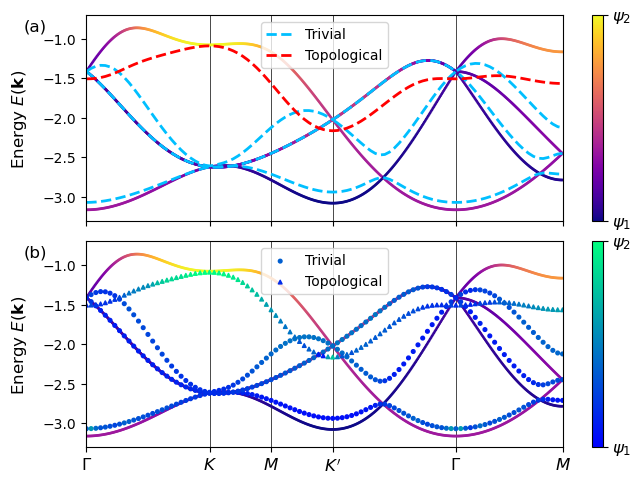

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)

fig, ax = model.plot_bands(
    k_path, nk=501, k_label=k_label, scat_size=1, red_lat_idx=high_E_sites, cmap='plasma',
    fig=fig, ax=axs[0]
    )

# deficient bands
for n in range(interp_energies.shape[-1]):
    if n == 0:
        ax.plot(k_dist, interp_energies[:, n], lw=2, c='deepskyblue', ls='--', label='Trivial')
    else:
        ax.plot(k_dist, interp_energies[:, n], lw=2, c='deepskyblue', ls='--')

## complementary bands
for n in range(interp_energies_comp.shape[-1]):
    if n == 0:
        ax.plot(k_dist, interp_energies_comp[:, n], c='red', lw=2, ls='--', label='Topological')
    else:
        ax.plot(k_dist, interp_energies_comp[:, n], c='red', lw=2, ls='--')

# ax.set_title(title)
ax.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
ax.set_ylim(-3.3, -0.7)
ax.set_xticks([ ])
ax.legend()

#################################

# actual bands
fig, ax2 = model.plot_bands(
    k_path, nk=501, k_label=k_label, red_lat_idx=high_E_sites, scat_size=1, cmap='plasma',
    fig=fig, ax=axs[1], cbar=False
    )

### deficient bands
wt = abs(interp_unk)**2
col = np.sum([  wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies.shape[-1]):
    if n == 0:
        scat = ax2.scatter(
            k_dist, interp_energies[:, n], c=col[:, n], 
            cmap='winter', marker='o', s=7, vmin=0, vmax=1, zorder=2, label='Trivial')
    else:
        scat = ax2.scatter(
            k_dist, interp_energies[:, n], c=col[:, n], 
            cmap='winter', marker='o', s=7, vmin=0, vmax=1, zorder=2)
cbar = fig.colorbar(scat, ticks=[1,0])
cbar.ax.set_yticklabels([r'$\psi_2$', r'$\psi_1$'], size=12)
band_type = "def"
axs[0].text(-.17, -0.9, '(a)', size=12)

## complementary bands
wt = abs(interp_unk_comp)**2
col = np.sum([  wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies_comp.shape[-1]):
    if n == 0:
        scat = ax2.scatter(
            k_dist, interp_energies_comp[:, n], c=col[:, n], 
            cmap='winter', marker='^', s=7, vmin=0, vmax=1, zorder=2, label='Topological')
    else:
        scat = ax2.scatter(
            k_dist, interp_energies_comp[:, n], c=col[:, n], 
            cmap='winter', marker='^', s=7, vmin=0, vmax=1, zorder=2)

# cbar = fig.colorbar(scat, ticks=[1,0])
# cbar.ax.set_yticklabels([r'$\psi_1$', r'$\psi_2$'], size=12)
band_type = "comp"

# ax.set_title(title)
ax2.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
# ax2.set_ylabel(" ")
# ax2.set_yticks([ ])
ax2.set_ylim(-3.3, -0.7)
ax2.legend()
axs[1].text(-.17, -0.9, '(b)', size=12)


plt.subplots_adjust(top=.97, left=0.13, bottom=0.07, right=1.06)
plt.subplots_adjust(hspace=0.1)

# fig.set_size_inches()
# plt.savefig(f"images/interp_{band_type}_bands.png", dpi=700)
# plt.savefig(f"images/interp_all_bands_{save_sfx}.png", dpi=700)